In [51]:
import pandas as pd
import geopandas as gp
import skmob
from skmob.measures.individual import radius_of_gyration, number_of_locations
import random
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statannotations.Annotator import Annotator
from shapely import Point
%matplotlib inline
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':200})
sns.set_palette(sns.color_palette("colorblind"))

import sys
# sys.stdout = open('logfile_geolife', 'w')
sys.path.append('..')

import attack

In [36]:
# load data
clustering_result_data = gp.read_file("data/geolife/geolife_clustering_HL.geojson", geometry='geometry')

In [7]:
clustering_result_data.columns

Index(['TRIP_ID', 'TRIP_START', 'TRIP_END', 'TRIP_LEN_IN_MTRS', 'PERSON_ID',
       'TRIP_WD', 'TRIP_DATE', 'TRIP_DURATION_IN_MINS', 'HOUR',
       'clustering_HL', 'geometry'],
      dtype='object')

In [37]:
attack.evaluate(clustering_result_data.clustering_HL.tolist(), clustering_result_data)

Homogeneity: 0.899
Completeness: 0.507
V-measure: 0.649
Rand index: 0.968
ARI: 0.261
MI: 3.329
NMI: 0.649
AMI: 0.380
Cluster accuracy: 0.295


In [38]:
N_POINTS = 4

# Find user ids that have at least N_POINTS/2 + 1 trips
user_ids = clustering_result_data.groupby('PERSON_ID').TRIP_ID.nunique().reset_index().query('TRIP_ID > @N_POINTS/2').PERSON_ID.unique()

In [39]:
def compute_perf_scores(uid, n_points=N_POINTS):
    # get for random points from this user's trajectories
    coords = [list(x.coords) for x in clustering_result_data.query('PERSON_ID == @uid').geometry.tolist()]
    coords = [item for sublist in coords for item in sublist]
    rand_points = random.choices(coords, k=N_POINTS)

    # find all trajectories where these points are part of and get unique cluster ids
    clustering_result_data['contains_rand_points'] = clustering_result_data.geometry.apply(lambda x: 1 if len(set(x.coords).intersection(set(rand_points))) > 0 else 0)
    cluster_ids = clustering_result_data.query('contains_rand_points == 1').clustering_HL.unique()

    # get trips of cluster and the true nr of trips of this user
    cluster_trips = clustering_result_data.query('clustering_HL in @cluster_ids')
    n_cluster_trips = len(cluster_trips)
    n_cluster_user_trips = len(cluster_trips.query('PERSON_ID == @uid'))
    n_user_trips = len(clustering_result_data.query('PERSON_ID == @uid'))

    # calculate homogeneity, completeness, v-measure
    homogeneity = n_cluster_user_trips/n_cluster_trips
    completeness = n_cluster_user_trips/n_user_trips
    v_measure = (homogeneity + completeness)/2

    return homogeneity, completeness, v_measure


def evaluate_attack(n_draws_per_user=10):
    eval_scores = {'user_id': [], 'homogeneity': [], 'completeness': [], 'v_measure': []}
    
    # only evaluate user that have at least N_POINTS/2 + 1 trips
    for uid in tqdm(user_ids):
    
        h_scores, c_scores, v_scores = [], [], []
        for i in range(n_draws_per_user):
            h, c, v = compute_perf_scores(uid)
            h_scores.append(h)
            c_scores.append(c)
            v_scores.append(v)

        # uncomment the code block below to plot perf scores histogram for each user
#         kwargs = dict(alpha=0.5, bins=20)
#         plt.hist(h_scores, **kwargs, color='g', label='homog.')
#         plt.hist(c_scores, **kwargs, color='b', label='compl.')
#         # plt.hist(v_scores, **kwargs, color='r', label='v')
#         plt.gca().set(title=f'User {uid}: Attack Performance Scores', ylabel='Frequency')
#         plt.xlim(0,1)
#         plt.legend();
#         plt.show()

        eval_scores['user_id'].extend([uid] * len(h_scores))
        eval_scores['homogeneity'].extend(h_scores)
        eval_scores['completeness'].extend(c_scores)
        eval_scores['v_measure'].extend(v_scores)

    return pd.DataFrame.from_dict(eval_scores)

scores = evaluate_attack()

  0%|          | 0/68 [00:00<?, ?it/s]

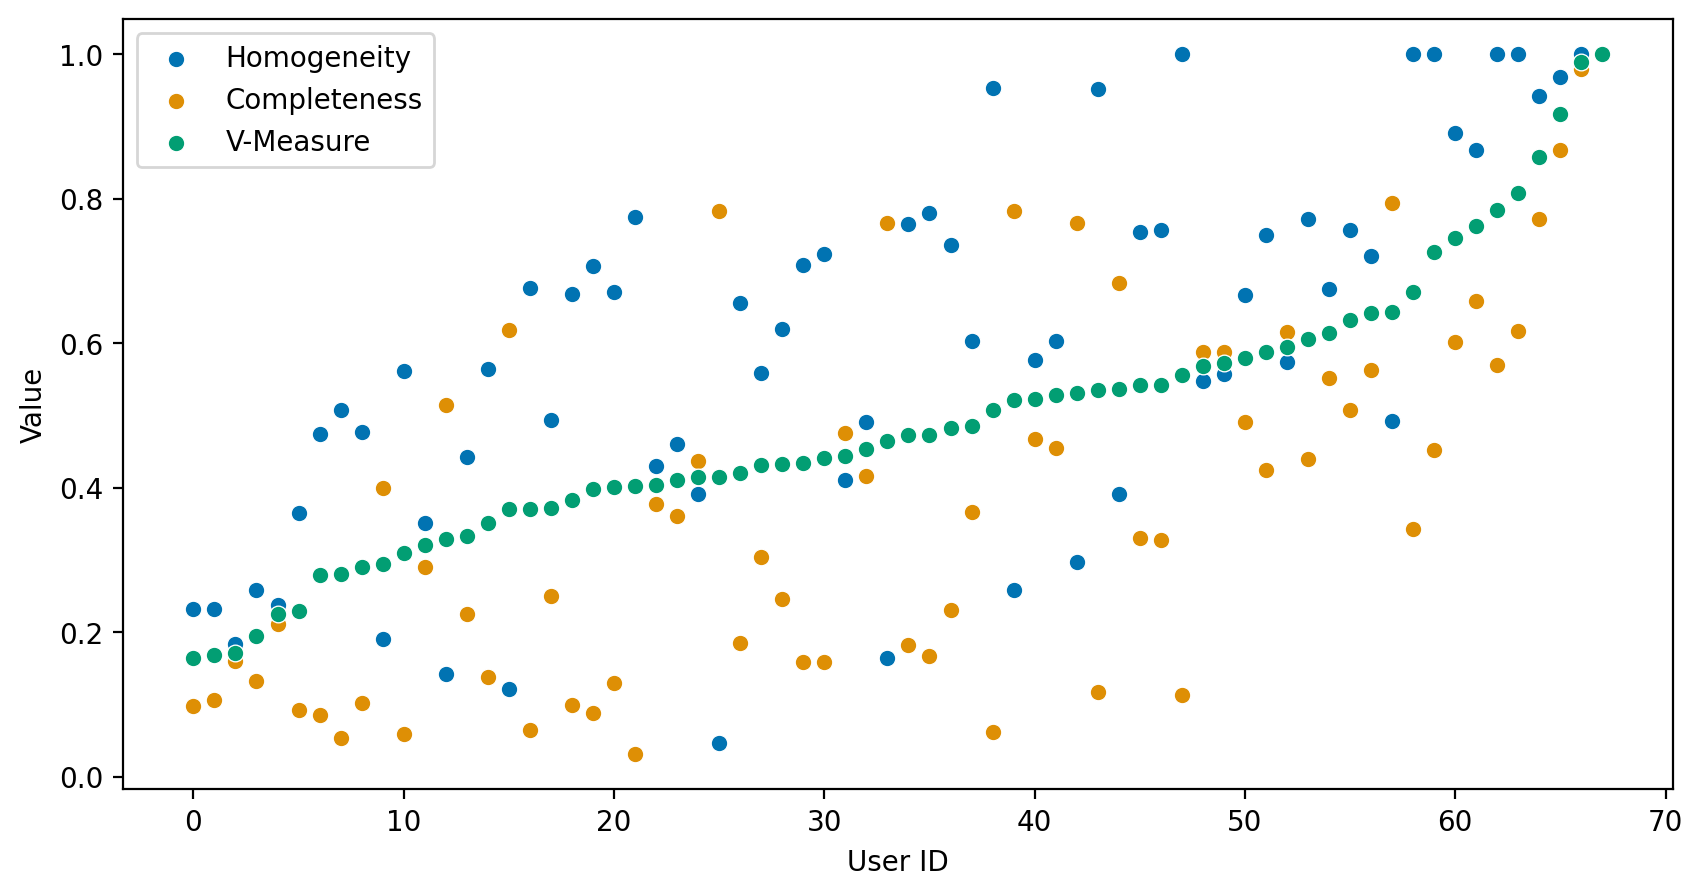

In [41]:
data_scatter = scores.groupby('user_id').mean().reset_index().astype({'user_id': 'category'})
data_scatter = data_scatter.sort_values('v_measure').reset_index(drop=True)
data_scatter['uid'] = range(0, len(data_scatter))

ax = sns.scatterplot(y='homogeneity', 
            x='uid', 
            data=data_scatter)
sns.scatterplot(y='completeness', 
            x='uid', 
            data=data_scatter)
sns.scatterplot(y='v_measure', 
            x='uid', 
            data=data_scatter)

ax.set_xlabel("User ID")
ax.set_ylabel( "Value")
ax.legend(['Homogeneity', 'Completeness', 'V-Measure'])

/tmp/ipykernel_30/1569992050.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_box = scores.groupby('user_id').mean().reset_index().astype({'user_id': 'category'})


Text(0, 0.5, 'V-Measure')

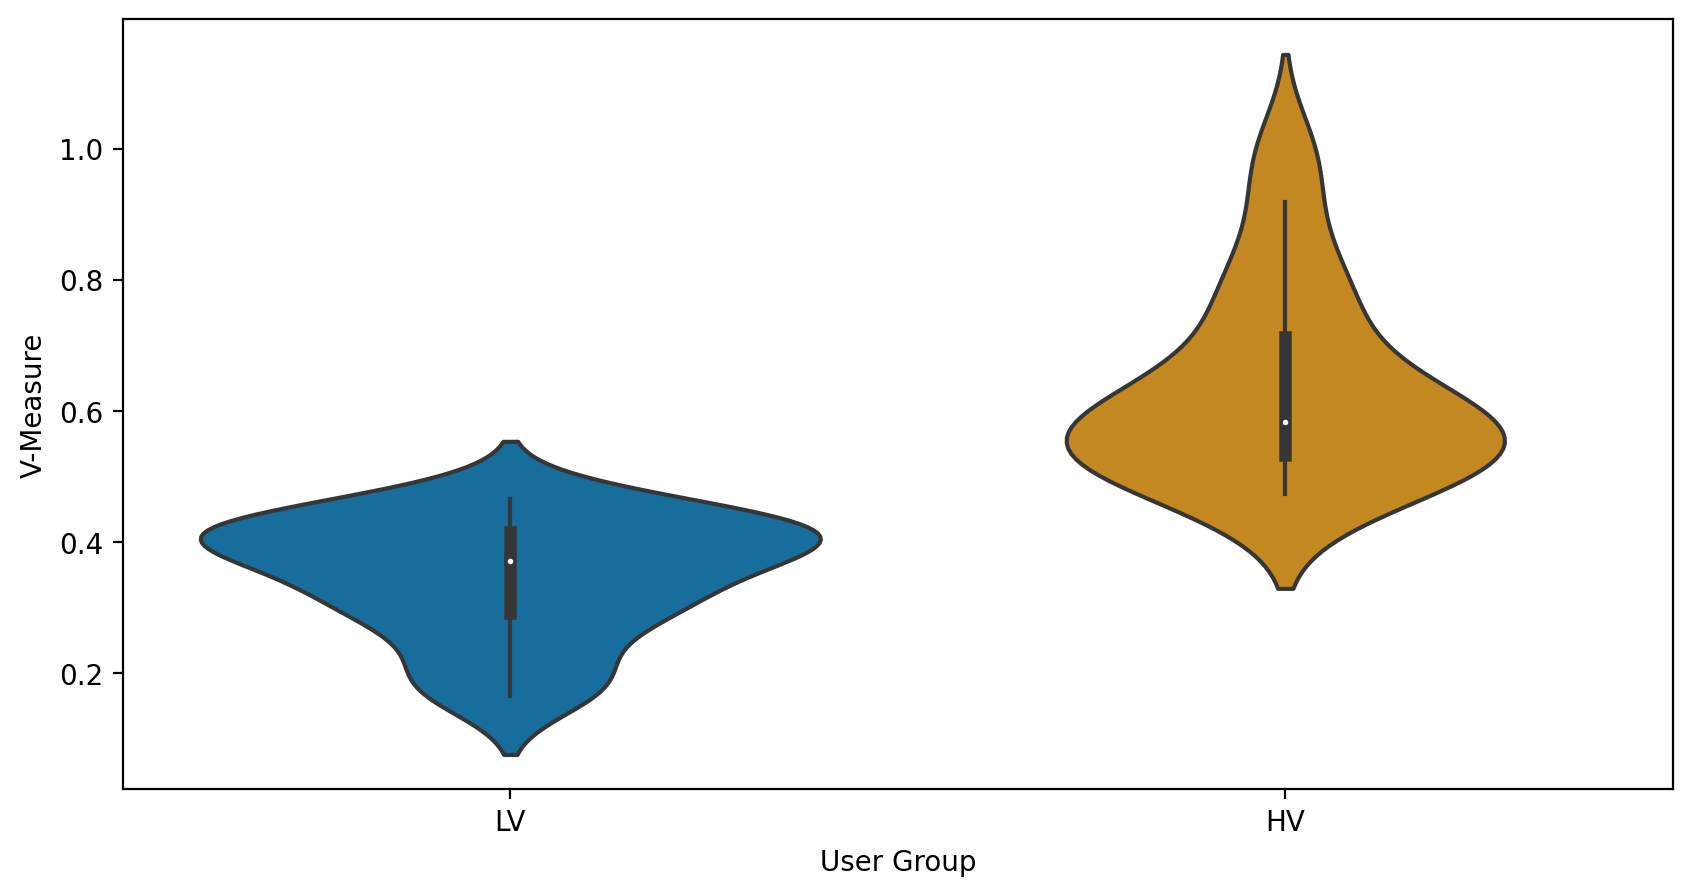

In [47]:
data_box = scores.groupby('user_id').mean().reset_index().astype({'user_id': 'category'})
data_box = data_box.sort_values('v_measure').reset_index(drop=True)
data_box['uid'] = range(0, len(data_box))

data_box.loc[data_box.v_measure > data_box.v_measure.quantile(0.5), 'group'] = "HV"
# data_box.loc[(data_box.v_measure > data_box.v_measure.quantile(0.33)) & (data_box.v_measure <= data_box.v_measure.quantile(0.66)), 'group'] = "b"
data_box.loc[data_box.v_measure <= data_box.v_measure.quantile(0.5), 'group'] = "LV"
pairs=[("LV", "HV")]


ax = sns.violinplot(
            y='v_measure', 
            x='group', 
            data=data_box)


ax.set_xlabel("User Group")
ax.set_ylabel( "V-Measure")

Text(0, 0.5, 'Value')

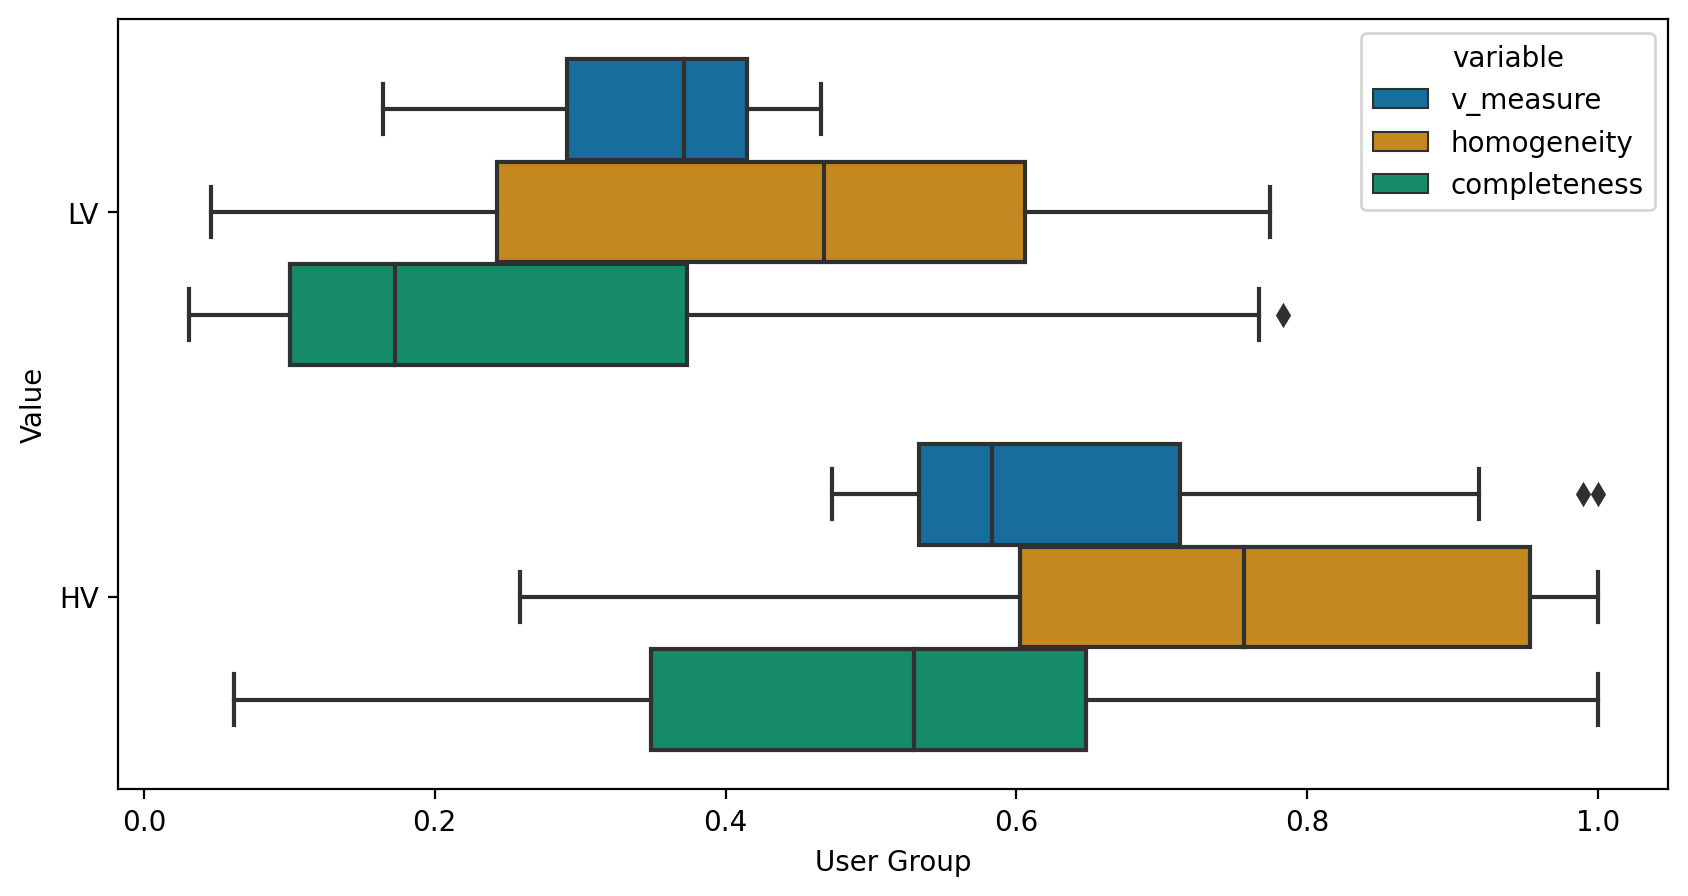

In [48]:
data_box = pd.melt(data_box, id_vars=['user_id', 'group'], value_vars=['v_measure', 'homogeneity', 'completeness'])


ax = sns.boxplot(
            x='value', 
            y='group',
            hue='variable',
            data=data_box)


ax.set_xlabel("User Group")
ax.set_ylabel( "Value")

Text(0.5, 0, 'n_trips')

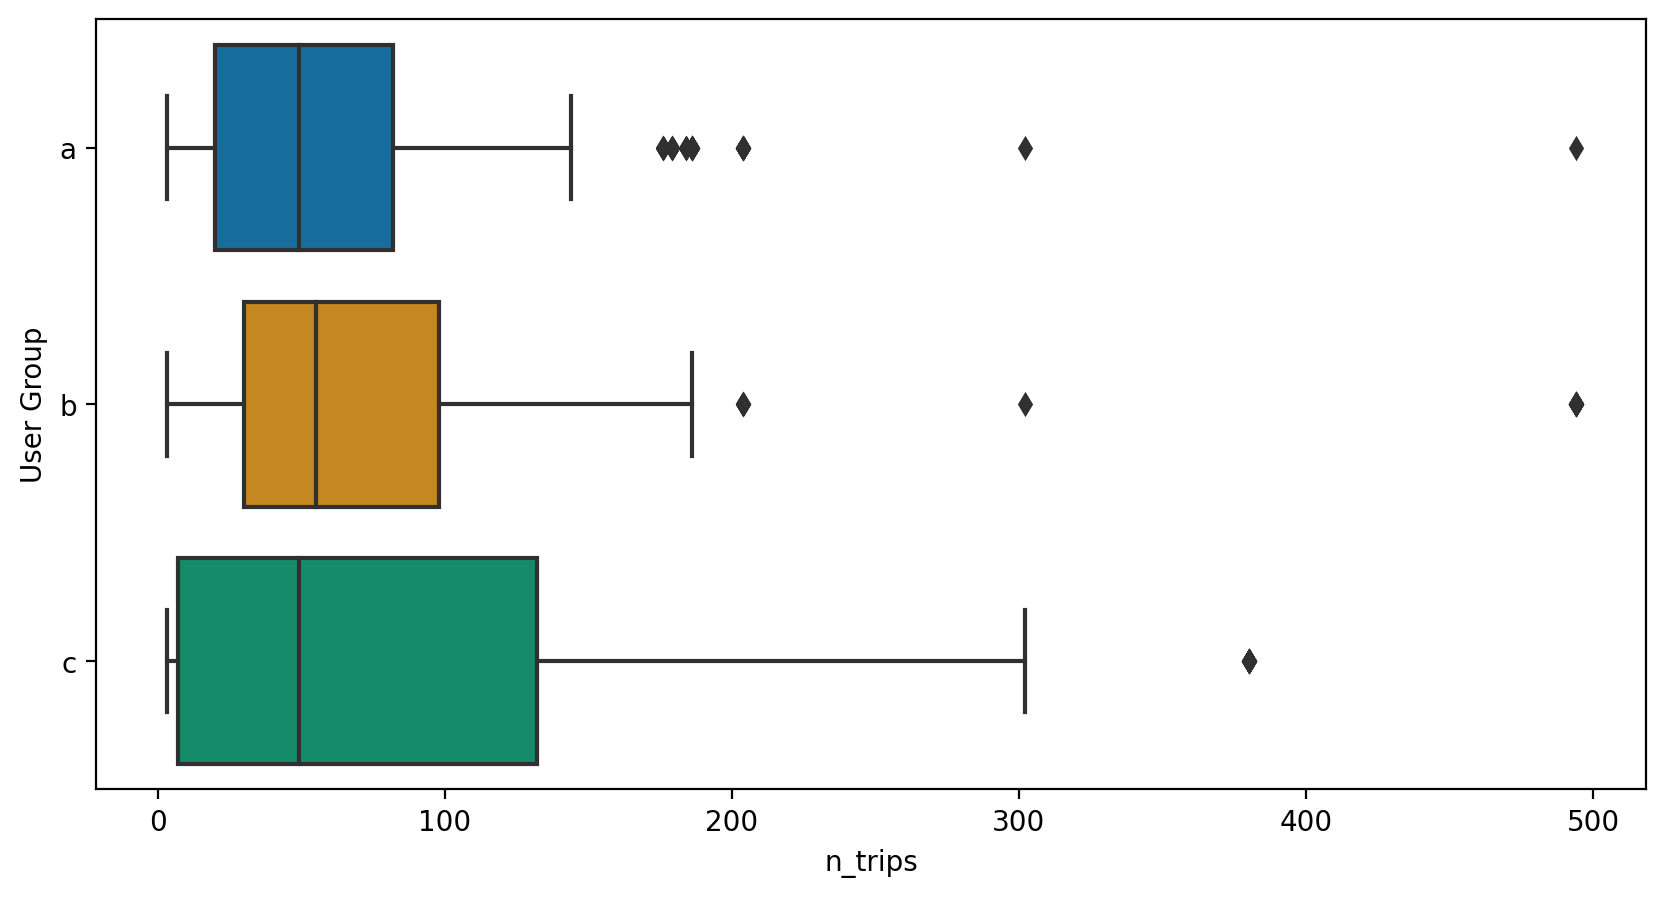

In [49]:
scores = pd.merge(scores, clustering_result_data.groupby('PERSON_ID').TRIP_ID.nunique().reset_index().query('TRIP_ID > @N_POINTS/2').rename(columns={'TRIP_ID': 'n_trips', 'PERSON_ID': 'user_id'}), how='left')

scores.loc[scores.v_measure > scores.v_measure.quantile(0.66), 'group'] = "c"
scores.loc[(scores.v_measure > scores.v_measure.quantile(0.33)) & (scores.v_measure <= scores.v_measure.quantile(0.66)), 'group'] = "b"
scores.loc[scores.v_measure <= scores.v_measure.quantile(0.33), 'group'] = "a"

ax = sns.boxplot(
            x='n_trips', 
            y='group',
            data=scores)


ax.set_ylabel("User Group")
ax.set_xlabel( "n_trips")

In [404]:
freemove_raw_points = gp.read_file("data/freemove/freemove_raw_point.geojson", geometry='geometry')

freemove_raw_points = freemove_raw_points.to_crs(4326)

freemove_raw_points['lon'] = freemove_raw_points.geometry.apply(lambda x: x.coords[0][0])
freemove_raw_points['lat'] = freemove_raw_points.geometry.apply(lambda x: x.coords[0][1])

tdf_freemove = skmob.TrajDataFrame(freemove_raw_points, latitude='lat', longitude='lon', datetime='time', user_id='user')

In [ ]:
rg = radius_of_gyration(tdf_freemove)

In [578]:
scores = pd.merge(scores, rg.rename(columns={'uid': 'user_id'}), how='left')

ax = sns.boxplot(
            x='radius_of_gyration', 
            y='group',
            data=scores)


ax.set_xlabel("User Group")
ax.set_ylabel("radius_of_gyration")

NameError: name 'rg' is not defined

In [54]:
clustering_result_data = clustering_result_data.to_crs(4326)
clustering_result_data['START_POINT'] = clustering_result_data.geometry.apply(lambda x: Point(x.coords[0]))
clustering_result_data['END_POINT'] = clustering_result_data.geometry.apply(lambda x: Point(x.coords[-1]))

tessellation = gp.read_file("data/geolife/tessellation_geolife_500.geojson", geometry='geometry').to_crs(4326)

def get_points(gdf, tessellation):
    sp = gdf[['PERSON_ID', 'TRIP_ID', 'TRIP_START', 'START_POINT', 'clustering_HL']].copy()
    ep = gdf[['PERSON_ID', 'TRIP_ID', 'TRIP_END', 'END_POINT', 'clustering_HL']].copy()


    sp['lat'] = sp.START_POINT.apply(lambda x: x.y)
    sp['lng'] = sp.START_POINT.apply(lambda x: x.x)
    ep['lat'] = ep.END_POINT.apply(lambda x: x.y)
    ep['lng'] = ep.END_POINT.apply(lambda x: x.x)

    sp = sp.rename(columns={'TRIP_START': 'datetime'})
    ep = ep.rename(columns={'TRIP_END': 'datetime'})

    sp.drop('START_POINT', axis=1, inplace=True)
    ep.drop('END_POINT', axis=1, inplace=True)

    points = pd.concat([sp, ep])
    points = gp.GeoDataFrame(points, geometry=gp.points_from_xy(points.lng, points.lat, crs='epsg:4326'))
    
    points = gp.sjoin(points, tessellation, predicate='within', how='left').drop('index_right', axis=1)
    
    return points

In [55]:
re = get_points(clustering_result_data, tessellation).groupby('PERSON_ID').apply(lambda g: math.log2(g.tile_id.nunique())).reset_index().rename(columns={0: 'rand_entropy', 'PERSON_ID': 'user_id'})

Text(0.5, 0, 'rand_entropy start and end points')

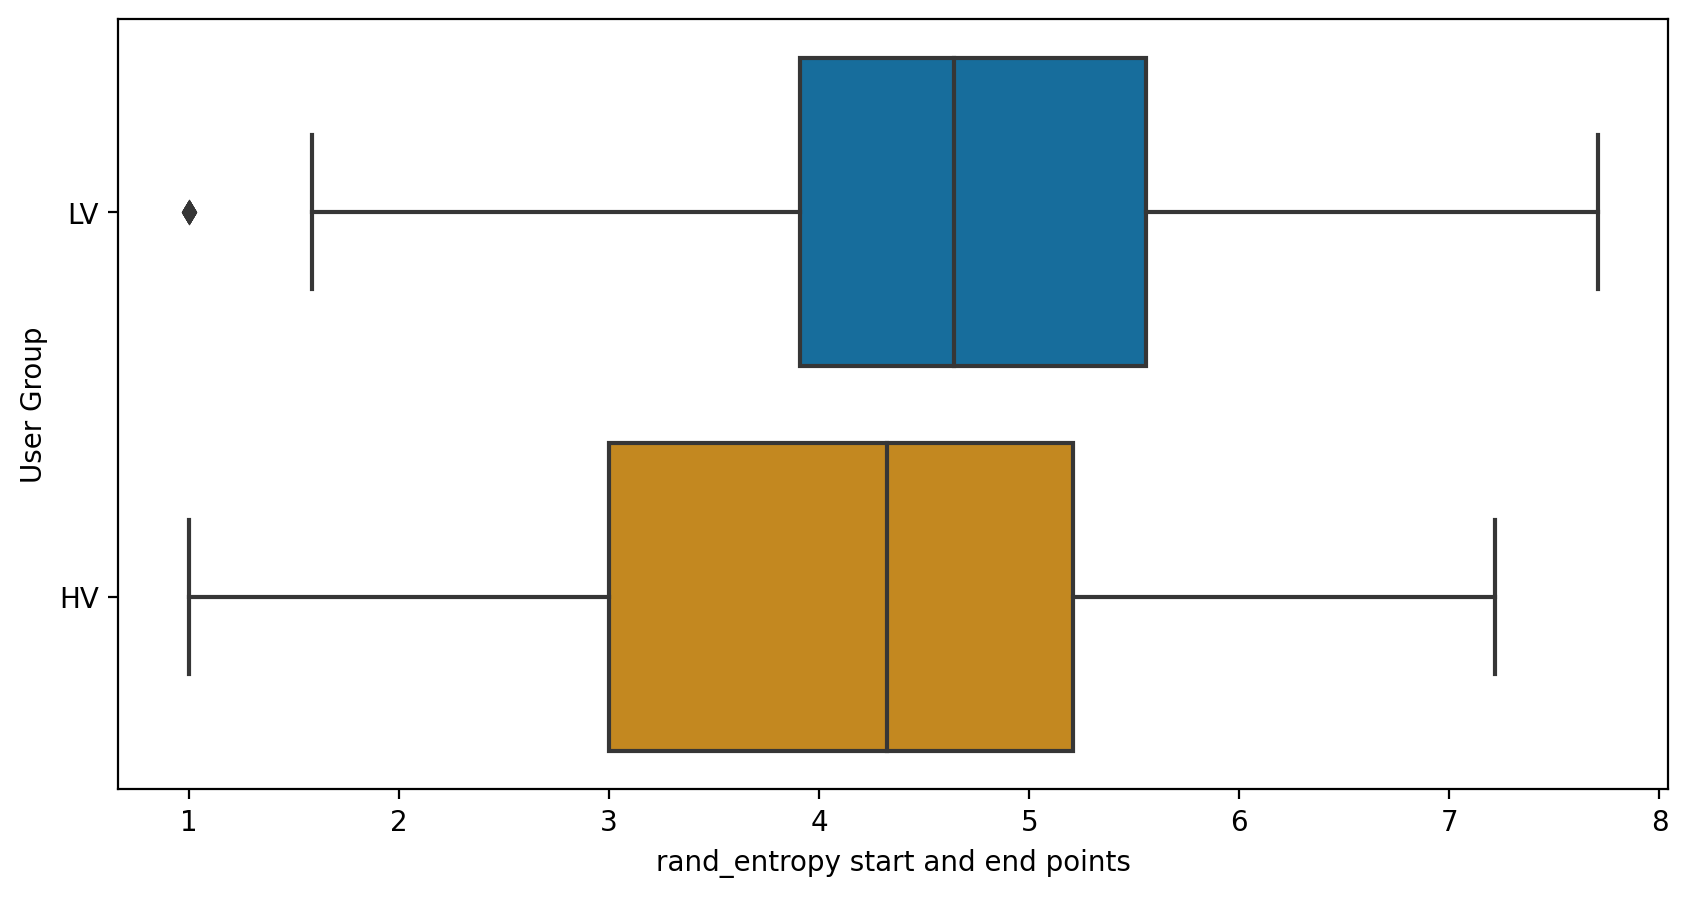

In [56]:
scores = pd.merge(scores, re, how='left')

ax = sns.boxplot(
            x='rand_entropy', 
            y='group',
            data=scores)


ax.set_ylabel("User Group")
ax.set_xlabel("rand_entropy start and end points")

In [57]:
mapped_points_gdf = get_points(clustering_result_data, tessellation)

def get_location_entropy(tile_id, mapped_points_gdf):
    assert isinstance(tile_id, str)
    t_trips = mapped_points_gdf.query("tile_id == @tile_id")
    le = 0
    c_l = len(t_trips)
    for p in t_trips.clustering_HL:
        c_l_u = len(t_trips.query('clustering_HL == @p'))
        p_u_l =  c_l_u/ c_l
        le += p_u_l * math.log(p_u_l)
    return -le

mapped_points_gdf['ale'] = mapped_points_gdf.tile_id.progress_apply(lambda x: get_location_entropy(x, mapped_points_gdf))
scores = pd.merge(scores, mapped_points_gdf[['PERSON_ID', 'ale']].groupby('PERSON_ID').mean().reset_index().rename(columns={'PERSON_ID': 'user_id'}), how='left')

  0%|          | 0/10202 [00:00<?, ?it/s]

LV vs. HV: Welch's t-test independent samples, P_val:5.918e-02 t=1.888e+00
LV vs. HV: Welch's t-test independent samples, P_val:8.234e-14 t=7.547e+00
LV vs. HV: Welch's t-test independent samples, P_val:2.885e-05 t=4.197e+00


Text(1295.8120915032682, 0.5, 'Random Entropy')

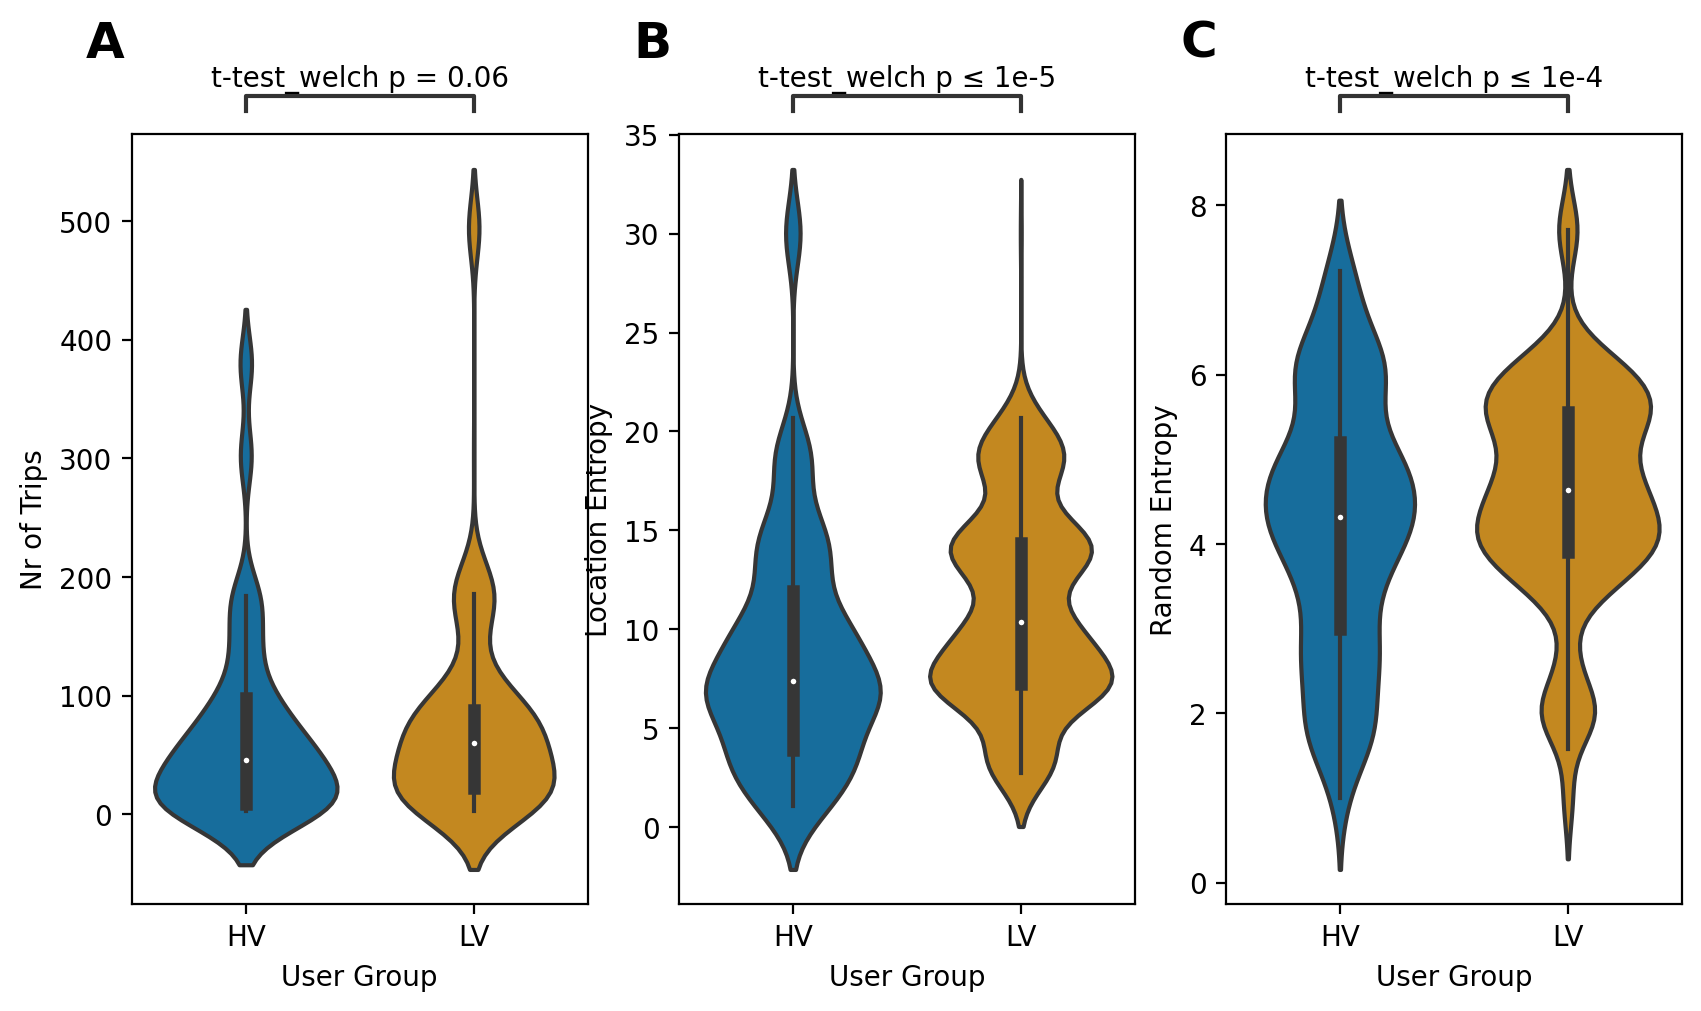

In [73]:
scores = pd.merge(scores, clustering_result_data.groupby('PERSON_ID').TRIP_ID.nunique().reset_index().query('TRIP_ID > @N_POINTS/2').rename(columns={'TRIP_ID': 'n_trips', 'PERSON_ID': 'user_id'}), how='left')

scores.loc[scores.v_measure > scores.v_measure.quantile(0.5), 'group'] = "HV"
# scores.loc[(scores.v_measure > scores.v_measure.quantile(0.33)) & (scores.v_measure <= scores.v_measure.quantile(0.66)), 'group'] = "b"
scores.loc[scores.v_measure <= scores.v_measure.quantile(0.5), 'group'] = "LV"

f, (ax_1, ax_2, ax_3) = plt.subplots(ncols=3, sharex=True)

ax = sns.violinplot(
            y='n_trips', 
            x='group',
            data=scores,
            order=['HV', 'LV'],
            ax=ax_1)
annotator = Annotator(ax_1, pairs, data=scores, x='group', y='n_trips')
annotator.configure(test='t-test_welch', text_format='simple', loc='outside')
annotator.apply_and_annotate()

ax = sns.violinplot(
            y='ale', 
            x='group',
            data=scores,
            order=['HV', 'LV'],
            ax=ax_2)
annotator = Annotator(ax_2, pairs, data=scores, x='group', y='ale')
annotator.configure(test='t-test_welch', text_format='simple', loc='outside')
annotator.apply_and_annotate()

ax = sns.violinplot(
            y='rand_entropy', 
            x='group',
            data=scores,
            order=['HV', 'LV'],
            ax=ax_3)
annotator = Annotator(ax_3, pairs, data=scores, x='group', y='rand_entropy')
annotator.configure(test='t-test_welch', text_format='simple', loc='outside')
annotator.apply_and_annotate()


import string
ax_1.text(-2.5, 1.1, string.ascii_uppercase[0], transform=ax.transAxes, 
            size=18, weight='bold')
ax_2.text(-1.3, 1.1, string.ascii_uppercase[1], transform=ax.transAxes, 
            size=18, weight='bold')
ax_3.text(-0.1, 1.1, string.ascii_uppercase[2], transform=ax.transAxes, 
            size=18, weight='bold')


ax_1.set_xlabel("User Group")
ax_1.set_ylabel("Nr of Trips")
ax_2.set_xlabel("User Group")
ax_2.set_ylabel("Location Entropy")
ax_3.set_xlabel("User Group")
ax_3.set_ylabel("Random Entropy")

Text(0.5, 0, 'avg location entropy')

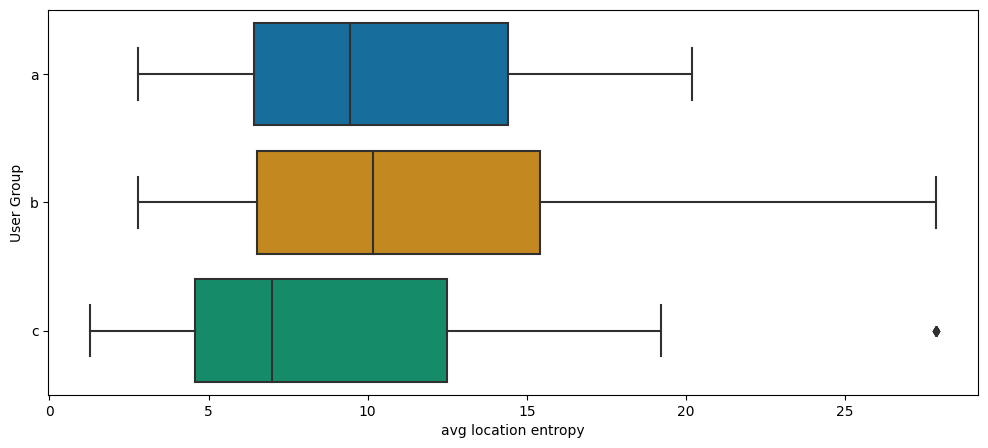

In [23]:
scores = pd.merge(scores, mapped_points_gdf[['PERSON_ID', 'le']].groupby('PERSON_ID').mean().reset_index().rename(columns={'PERSON_ID': 'user_id'}), how='left')

ax = sns.boxplot(
            x='le', 
            y='group',
            data=scores)


ax.set_ylabel("User Group")
ax.set_xlabel("avg location entropy")

In [24]:
clustering_result_data['hour_of_day'] = pd.to_datetime(clustering_result_data.TRIP_START).dt.hour - 1

<Axes: xlabel='hour_of_day', ylabel='Density'>

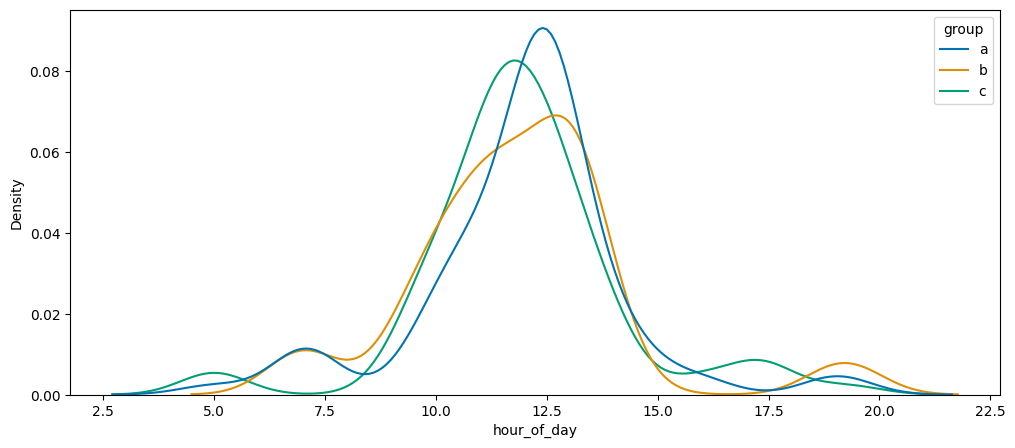

In [26]:
scores = pd.merge(scores, clustering_result_data[['PERSON_ID', 'hour_of_day']].groupby('PERSON_ID').mean().reset_index().rename(columns={'PERSON_ID': 'user_id'}), how='left')

sns.kdeplot(data=scores, x="hour_of_day", hue="group")